## Placeholder for Table of Contents Bug on AWS

## Placeholder for Table of Contents Bug on AWS

## Placeholder for Table of Contents Bug on AWS

## Placeholder for Table of Contents Bug on AWS

# Imports

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import ta

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
from pprint import pprint

import gc
import optuna
from sklearn.feature_selection import RFE

In [2]:
df = pd.read_csv('Data/Training/pair_features1_300_60.csv')
df.head()

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,abs_spread_normed_max,abs_spread_normed_90th,abs_spread_normed_75th,abs_spread_normed_median,abs_spread_normed_l7_avg,abs_spread_normed_l14_avg,cos_sim,corr_coef,pnls,num_entries
0,2015-01-02,CAG,21.161,NOC,126.094,28.241,149.160,27.868,144.540,5126379.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-05,CAG,20.931,NOC,123.433,28.023,146.470,27.564,142.450,5400213.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-06,CAG,20.724,NOC,124.114,27.743,146.000,27.167,141.580,5229051.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-07,CAG,21.214,NOC,128.040,27.977,148.830,27.432,144.880,3124092.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-08,CAG,21.675,NOC,131.010,28.560,153.140,28.054,149.810,4154019.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df['pnls'] = df['pnls']*100.0

In [4]:
total_days = df.Date.nunique()
total_days

1257

In [5]:
print(df.shape)
df.isna().sum()

(1257000, 27)


Date                              0
Ticker_P1                         0
Close_P1                          0
Ticker_P2                         0
Close_P2                          0
High_P1                           0
High_P2                           0
Low_P1                            0
Low_P2                            0
Volume_P1                         0
Volume_P2                         0
abs_spread                        0
abs_spread_mean              299000
abs_spread_std               299000
abs_spread_mean_l28           27000
abs_spread_std_l28            27000
spread_normed                299000
abs_spread_normed_max        598000
abs_spread_normed_90th       598000
abs_spread_normed_75th       598000
abs_spread_normed_median     598000
abs_spread_normed_l7_avg     305000
abs_spread_normed_l14_avg    312000
cos_sim                      299000
corr_coef                    299000
pnls                         360000
num_entries                  360000
dtype: int64

In [6]:
df.Date.nunique()

1257

In [7]:
df.abs_spread_normed_max.dropna().describe()

count   659000.000
mean         3.137
std          0.610
min          1.280
25%          2.786
50%          3.052
75%          3.363
max          6.871
Name: abs_spread_normed_max, dtype: float64

In [8]:
df = df.sort_values('Date')

In [9]:
print(df.Date.min(),df.Date.max())

2015-01-02 2019-12-30


# Feature Engineering

In [10]:
# TODO:
# 1. Add group based features
# 2. Stock2Vec based features
# 3. Add Technical Indicators
# 4. target is a sum of 2 directions with magnitudes (how much it goes up/down per leg)
# 5. rolling features
# 6. probability of classification model
# 7. historical pnl and num_entries, drop leaky num_entries
# 8. differencing features.

In [11]:
# 3 dimensions from a product perspective: ticker1, ticker2, and pair
# 2 dimensions from a time perspective: short term vs long term
# 2 factors of PnL: Volatility, and Reversion to mean

# short term ticker 1 volatility: rolling mean, sector rolling mean, rolling std, sector rolling std
# short term ticker 2 volatility: rolling mean, sector rolling mean, rolling std, sector rolling std
# short term pair level volatility: rolling mean, sector rolling mean, rolling std, sector rolling std, 
#                                   differences of ticker level features

# long term ticker 1 volatility: beta,
# long term ticker 2 volatility: beta,
# long term pair level volatility: most recent PNL (which is from 120 days ago), average historical PNL
#                                  most recent number of entries, historical average vnumber of entries, 
#                                  diff of beta

# short term ticker 1 reversion to mean: technical indicators
# short term ticker 2 reversion to mean: technical indicators
# short term pair level reversion to mean: technical indicators

# long term ticker 1 reversion to mean: technical indicators
# long term ticker 2 reversion to mean: technical indicators
# long term pair level reversion to mean: technical indicators

## Technical Indicators

In [12]:
class feature_engineering(object):
    def __init__(self):
        super(feature_engineering, self).__init__()

    def generate_technical_indicator(self, data_df): 
        '''
        Function to generate additional technical indicators for the stock

        Uses the "statsmodels.tsa.stattools" (as "ts") package to apply 
        the equations specified in the "Technical Indicators" markdown section 
        to stock closing data.
        
        Input:
        data_df-- Dataframe containing stock finacials data
        
        Output:
        Stock finacials data with added Dataframe of feature obtained from feature engineering
        ''' 
        # 1. Momentum Indicators
        # Relative Strength Index
        df = data_df
        df['rsi'] = ta.momentum.rsi(df['Close'], window=14)
        # Kaufman’s Adaptive Moving Average (KAMA)
        df['kama'] = ta.momentum.kama(df['Close'],window=14)

        # 2. Volume Indicators
        # Accumulation/Distribution Index (ADI)
        df['adi'] = ta.volume.acc_dist_index(df['High'], df['Low'], df['Close'], df['Volume'])

        # Volume-price trend (VPT)
        df['vpt'] = ta.volume.volume_price_trend(df['Close'], df['Volume'])

        # 3. Volatility Indicators
        # Average True Range (ATR)
        df['atr'] = ta.volatility.average_true_range(df['High'], df['Low'],df['Close'], window=14)

        # Bollinger Bands (BB) N-period simple moving average (MA)
        df['bb_ma'] = ta.volatility.bollinger_mavg(df['Close'], window=20)

        # 4. Trend Indicators
        # Average Directional Movement Index (ADX)
        df['adx'] = ta.trend.adx(df['High'], df['Low'], df['Close'], window=14)

        # Exponential Moving Average
        df['ema'] = ta.trend.ema_indicator(df['Close'], window=14)

        # Moving Average Convergence Divergence (MACD)
        df['macd'] = ta.trend.macd(df['Close'], window_fast=14, window_slow=30)

        # 5. Other Indicators
        # Daily Log Return (DLR)
        df['dlr'] = ta.others.daily_log_return(df['Close'])

        # Daily Returns
        df['daily_returns'] = df['Close'].pct_change()

        # Moving Averages
        averages = [50,200]
        for avg in averages:
            col_name = str(avg) +' Days Average'
            df[col_name] = df['Close'].rolling(window = avg, center = False).mean()

        return df

### Load SPY

In [ ]:
spy_df = pd.read_csv('Data/Training/1999-12-01-2023-12-31.csv')
spy_df = spy_df[['Date','Adj Close']]
spy_df.columns = ['Date','SPY_Close']
df = pd.merge(df,spy_df,on='Date',how='left')

In [ ]:
del spy_df
gc.collect()

### Beta

In [ ]:
def compute_beta(rs,df,ticker,market):
    rows = df.loc[rs.index]
    sec_returns = np.log( df[[ticker,market]] / df[[ticker,market]].shift(1) ) 

    cov = sec_returns.cov() * 250
    cov_with_market = cov.iloc[0,1]
    market_var = sec_returns[market].var() * 250
    beta = cov_with_market / market_var
    return beta

In [ ]:
all_tickers = df['Ticker_P1'].unique().tolist()+df['Ticker_P2'].unique().tolist()
len(all_tickers)

In [ ]:
fe_obj = feature_engineering()


### Single Ticker Features

In [ ]:
df.columns

In [ ]:
all_tickers_df_list = []
for t in tqdm(all_tickers):
    single_ticker_df = (df[df['Ticker_P1']==t] if t in df['Ticker_P1'].unique() else df[df['Ticker_P2']==t])
    single_ticker_df = single_ticker_df.sort_values('Date')
    single_ticker_df = single_ticker_df[['Date','Ticker_P1','Close_P1','High_P1','Low_P1','Volume_P1','SPY_Close']] if t in df['Ticker_P1'].unique() else\
                       single_ticker_df[['Date','Ticker_P2','Close_P2','High_P2','Low_P2','Volume_P2','SPY_Close']]
    single_ticker_df.columns = ['Date','Ticker','Close','High','Low','Volume','SPY_Close']
    single_ticker_df = single_ticker_df.drop_duplicates()

    single_ticker_df['rolling_beta'] = single_ticker_df['Close'].rolling(300).progress_apply(compute_beta, \
                                        args=(single_ticker_df,'Close','SPY_Close'))

    single_ticker_df_with_technical_indicators = fe_obj.generate_technical_indicator(single_ticker_df)

    all_tickers_df_list.append(single_ticker_df_with_technical_indicators)


In [ ]:
all_tickers_df = pd.concat(all_tickers_df_list,axis=0,ignore_index=True).reset_index(drop=True)
all_tickers_df.shape

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df.tail(2)

In [ ]:
all_tickers_df.tail(2)

In [ ]:
print(df.shape)
all_tickers_df_P1_suffix = all_tickers_df.copy()
all_tickers_df_P1_suffix.columns = ['Date','Ticker']+[c+'_P1' for c in all_tickers_df.columns if c not in ['Date','Ticker']]
all_tickers_df_P2_suffix = all_tickers_df.copy()
all_tickers_df_P2_suffix.columns = ['Date','Ticker']+[c+'_P2' for c in all_tickers_df.columns if c not in ['Date','Ticker']]

df = pd.merge(df,all_tickers_df_P1_suffix,left_on=['Date','Ticker_P1'],right_on=['Date','Ticker'],\
              how='left',suffixes=['','_P1']).drop_duplicates()
print(df.shape)
df = pd.merge(df,all_tickers_df_P2_suffix,left_on=['Date','Ticker_P2'],right_on=['Date','Ticker'],\
              how='left',suffixes=['','_P2']).drop_duplicates()
print(df.shape)
df = df.loc[:,~df.columns.duplicated()]
print(df.shape)


In [ ]:
del all_tickers_df_P1_suffix, all_tickers_df_P2_suffix
gc.collect()

In [ ]:
df = df.drop('Ticker',axis=1)

## Add group based features

### Merge Sector

In [ ]:
sector_df = pd.read_csv('/home/ec2-user/Capstone/1999-12-01-2023-12-31.csv')
sector_df = sector_df.drop_duplicates(subset=['Ticker','GICS Sector'])[['Ticker','GICS Sector']]
sector_df

In [ ]:
industry_df = pd.read_csv('/home/ec2-user/Capstone/1999-12-01-2023-12-31.csv')
industry_df = industry_df.drop_duplicates(subset=['Ticker','GICS Sub-Industry'])[['Ticker','GICS Sub-Industry']]
industry_df

In [ ]:
df = pd.merge(df,sector_df.rename(columns={'GICS Sector':'Sector_P1'}),how='left',left_on='Ticker_P1',right_on='Ticker').drop('Ticker',axis=1)
df = pd.merge(df,sector_df.rename(columns={'GICS Sector':'Sector_P2'}),how='left',left_on='Ticker_P2',right_on='Ticker').drop('Ticker',axis=1)
df = pd.merge(df,industry_df.rename(columns={'GICS Sub-Industry':'Industry_P1'}),how='left',left_on='Ticker_P1',right_on='Ticker').drop('Ticker',axis=1)
df = pd.merge(df,industry_df.rename(columns={'GICS Sub-Industry':'Industry_P2'}),how='left',left_on='Ticker_P2',right_on='Ticker').drop('Ticker',axis=1)

In [ ]:
del sector_df
del industry_df
gc.collect()

### Prev Values

In [ ]:
df = df.sort_values('Date')

In [ ]:
df['PREV_num_entries'] = df.groupby(['Ticker_P1','Ticker_P2']).num_entries.shift(61)
df['PREV_pnls'] = df.groupby(['Ticker_P1','Ticker_P2']).pnls.shift(61)

# Trim head and tail days

In [ ]:
print(df.shape)
df = df.drop(df.groupby(['Ticker_P1','Ticker_P2']).head(301).index,axis=0)
print(df.shape)
df = df.drop(df.groupby(['Ticker_P1','Ticker_P2']).tail(61).index,axis=0)
print(df.shape)


### Sector

In [ ]:
all_sectors = df['Sector_P1'].unique().tolist()+df['Sector_P2'].unique().tolist()
len(all_sectors)

In [ ]:
all_sectors_df_list = []
for s in tqdm(all_sectors):
    single_sector_df = (df[df['Sector_P1']==s] if s in df['Sector_P1'].unique() else df[df['Sector_P2']==s])
    single_sector_df = single_sector_df.sort_values('Date')

    single_sector_df = single_sector_df[['Date','Sector_P1','daily_returns_P1','rolling_beta_P1']] if s in df['Sector_P1'].unique() else\
                       single_sector_df[['Date','Sector_P2','daily_returns_P2','rolling_beta_P2']]
    single_sector_df.columns = ['Date','Sector','daily_returns','rolling_beta']
    single_sector_df = single_sector_df.drop_duplicates()

    single_sector_df['sector_rolling_beta_mean'] = single_sector_df.groupby('Date').rolling_beta.transform(np.nanmean)
    single_sector_df['sector_rolling_beta_std'] = single_sector_df.groupby('Date').rolling_beta.transform(np.nanstd)
    single_sector_df['sector_daily_return_mean'] = single_sector_df.groupby('Date').daily_returns.transform(np.nanmean)
    single_sector_df['sector_daily_return_std'] = single_sector_df.groupby('Date').daily_returns.transform(np.nanstd)

    all_sectors_df_list.append(single_sector_df)


/tmp/ipykernel_15338/2923332618.py:11: FutureWarning: The provided callable <function nanmean at 0x7fa504732cb0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  single_sector_df['sector_rolling_beta_mean'] = single_sector_df.groupby('Date').rolling_beta.transform(np.nanmean)
/tmp/ipykernel_15338/2923332618.py:12: FutureWarning: The provided callable <function nanstd at 0x7fa504733880> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  single_sector_df['sector_rolling_beta_std'] = single_sector_df.groupby('Date').rolling_beta.transform(np.nanstd)
/tmp/ipykernel_15338/2923332618.py:13: FutureWarning: The provided callable <function nanmean at 0x7fa504732cb0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided calla

/tmp/ipykernel_15338/2923332618.py:11: FutureWarning: The provided callable <function nanmean at 0x7fa504732cb0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  single_sector_df['sector_rolling_beta_mean'] = single_sector_df.groupby('Date').rolling_beta.transform(np.nanmean)
/tmp/ipykernel_15338/2923332618.py:12: FutureWarning: The provided callable <function nanstd at 0x7fa504733880> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  single_sector_df['sector_rolling_beta_std'] = single_sector_df.groupby('Date').rolling_beta.transform(np.nanstd)
/tmp/ipykernel_15338/2923332618.py:13: FutureWarning: The provided callable <function nanmean at 0x7fa504732cb0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided calla

In [ ]:
all_sectors_df = pd.concat(all_sectors_df_list,axis=0,ignore_index=True).reset_index(drop=True)
all_sectors_df.tail(2)

In [ ]:
# stop

In [ ]:
# print(df.shape)
# all_sectors_df = all_sectors_df.drop(['daily_returns','rolling_beta'],axis=1).drop_duplicates()
# all_sectors_df_P1_suffix = all_sectors_df.copy()
# all_sectors_df_P1_suffix.columns = ['Date','Sector']+[c+'_P1' for c in all_sectors_df.columns if c not in ['Date','Sector']]
# all_sectors_df_P2_suffix = all_sectors_df.copy()
# all_sectors_df_P2_suffix.columns = ['Date','Sector']+[c+'_P2' for c in all_sectors_df.columns if c not in ['Date','Sector']]

# df = pd.merge(df,all_sectors_df_P1_suffix,left_on=['Date','Sector_P1'],right_on=['Date','Sector'],\
#               how='left',suffixes=['','_P1']).drop_duplicates()
# print(df.shape)
# df = pd.merge(df,all_sectors_df_P2_suffix,left_on=['Date','Sector_P2'],right_on=['Date','Sector'],\
#               how='left',suffixes=['','_P2']).drop_duplicates()
# print(df.shape)
# df = df.loc[:,~df.columns.duplicated()]
# print(df.shape)

In [ ]:
# del all_sectors_df_P1_suffix, all_sectors_df_P2_suffix
# gc.collect()

### Diff Values

In [ ]:
for c in ['Close', 'High', 'Low', 'Volume', 'rolling_beta', 'rsi', 'kama',
       'adi', 'vpt', 'atr', 'bb_ma', 'adx', 'ema', 'macd', 'dlr',
       'daily_returns', '50 Days Average', '200 Days Average']:
# ,
#        'sector_rolling_beta_mean', 'sector_rolling_beta_std',
#        'sector_daily_return_mean', 'sector_daily_return_std']:
    df['DIFF_'+c] = df[c+'_P1'] - df[c+'_P2']

In [ ]:
df['DIFF_abs_spread_mean_l28_500'] = df['abs_spread_mean_l28'] - df['abs_spread_mean']

In [ ]:
df.isna().sum().sort_values(ascending=False).head(20)

In [ ]:
# stop

# Classification to predict PNL_IS_0

In [ ]:
categorical_features = ['Sector_P1','Sector_P2','Industry_P1','Industry_P2']

In [ ]:
for c in categorical_features:
    df[c] = df[c].astype('category')

In [ ]:
df.head()

## X,y split

In [ ]:
df['PNL_IS_0'] = np.where(df.pnls==0,1,0)

In [ ]:
df.columns

In [ ]:
features = df.drop(categorical_features+['PNL_IS_0']+\
                   ['abs_spread_normed_max','abs_spread_normed_median',\
                    'abs_spread_normed_75th','abs_spread_normed_90th',\
                    'Date','Ticker_P1','Ticker_P2','SPY_Close_P1','SPY_Close_P2',\
                    'num_entries','pnls']+[c for c in df.columns if '_P1_P1' in c or '_P2_P2' in c],axis=1).columns.tolist()+categorical_features
label = 'PNL_IS_0'

In [ ]:
print(df.shape)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna(subset=features)
print(df.shape)


In [ ]:
print(df.Date.min(),df.Date.max())

In [ ]:
X = df[features]
y = df[label]

## Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

In [ ]:
print(df.loc[X_val.index].Date.min(),df.loc[X_val.index].Date.max())

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

In [ ]:
y_train.value_counts()

In [ ]:
y_val.value_counts()

In [ ]:
y_test.value_counts()

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = undersample.fit_resample(X_train, y_train)

## Logistic Regression

In [ ]:
scaler = StandardScaler().fit(X_train.drop(categorical_features,axis=1))
scaled_X_train = scaler.transform(X_train.drop(categorical_features,axis=1))
scaled_X_val = scaler.transform(X_val.drop(categorical_features,axis=1))
scaled_X_test = scaler.transform(X_test.drop(categorical_features,axis=1))

In [ ]:
y.value_counts()

In [ ]:
clf = LogisticRegression()

# Train the model using the training sets
clf.fit(scaled_X_train, y_train)

# Make predictions using the testing set
lr_preds = clf.predict(scaled_X_test)

In [ ]:
print(f1_score(y_test, lr_preds, average='weighted'))
print(f1_score(y_test, lr_preds, average='micro'))
print(f1_score(y_test, lr_preds, average='macro'))

## Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, lr_preds, labels=clf.classes_,normalize='true')

In [ ]:
26955/(26955+5781)

In [ ]:
63650/(63650+8719)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

## Feature Importance

In [ ]:
pi = permutation_importance(clf,scaled_X_test,y_test)

coefs = pd.DataFrame(
    pi['importances_mean'], columns=["Coefficients"], index=X_train.drop(categorical_features,axis=1).columns
)

coefs.plot(kind="barh", figsize=(20, 7))
plt.title("Logistic Regression model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

## GBM

### Optuna

In [ ]:
def objective(trial):
    params = {
        'boosting':'dart',
        "objective": "binary",
#         "metric": "accuracy",
        'class_weight':'balanced',
        "n_estimators": 300,
        "verbosity": -1,
        "bagging_freq": 1,
        'max_bin':trial.suggest_int('max_bin',64,1024),
        'max_depth':trial.suggest_int('max_depth',4,20),

        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 3000),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 1000),
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train.drop(categorical_features,axis=1),y_train)
    predictions = model.predict(X_val.drop(categorical_features,axis=1))
    f1 = f1_score(y_val, predictions, average='weighted')
    return -1*f1

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2024-03-03 21:18:13,730] Trial 25 finished with value: -0.8195501350805173 and parameters: {'max_bin': 729, 'max_depth': 18, 'learning_rate': 0.021641617376577667, 'num_leaves': 283, 'subsample': 0.4460500130870911, 'colsample_bytree': 0.6736485871311326, 'min_data_in_leaf': 141}. Best is trial 11 with value: -0.8606576740229694.
[I 2024-03-03 21:19:02,980] Trial 26 finished with value: -0.8284681713003985 and parameters: {'max_bin': 844, 'max_depth': 16, 'learning_rate': 0.0059915157457021894, 'num_leaves': 1048, 'subsample': 0.8147567932697589, 'colsample_bytree': 0.8327509237893491, 'min_data_in_leaf': 379}. Best is trial 11 with value: -0.8606576740229694.
[I 2024-03-03 21:19:48,921] Trial 27 finished with value: -0.8342678902122821 and parameters: {'max_bin': 867, 'max_depth': 19, 'learning_rate': 0.002039293739211353, 'num_leaves': 556, 'subsample': 0.6975421047494481, 'colsample_bytree': 0.9120343022974968, 'min_data_in_leaf': 65}. Best is trial 11 with value: -0.860657674022

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best F1:', study.best_value*(-1))

In [ ]:
hyper_params = study.best_params

In [ ]:
y_train.value_counts()/len(y_train)

In [ ]:
gbm = lgb.LGBMClassifier(**hyper_params)
callbacks = [\
#             lgb.early_stopping(stopping_rounds=10, verbose=1,min_delta=0.001,first_metric_only=False), 
             lgb.log_evaluation(period=1)]

gbm.fit(X_train.drop(categorical_features,axis=1),y_train, 
        eval_set=[(X_val.drop(categorical_features,axis=1), y_val)],
        eval_metric='accuracy',
        callbacks=callbacks,
        feature_name = [f for f in features if f not in categorical_features],
#         categorical_feature=categorical_features
       )

In [ ]:
gbm_preds = gbm.predict(X_test.drop(categorical_features,axis=1))

In [ ]:
print(f1_score(y_test, gbm_preds, average='weighted'))
print(f1_score(y_test, gbm_preds, average='micro'))
print(f1_score(y_test, gbm_preds, average='macro'))

In [ ]:
cm = confusion_matrix(y_test, gbm_preds, labels=gbm.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbm.classes_)
disp.plot()

In [ ]:
importances = gbm.feature_importances_
importances = pd.Series(importances,index=X_train.drop(categorical_features,axis=1).columns).sort_values(ascending=True)

In [ ]:
fig,ax=plt.subplots(figsize=[16,14])
importances.plot.barh(ax=ax)
ax.set_title("Feature Importance by Gain")
fig.tight_layout()

In [ ]:
# STOP

# Regression

## Remove 0s?

In [ ]:
df[df.pnls==0].shape[0]*100.0/df.shape[0]

In [ ]:
df = df[df.pnls!=0]


## X,y split

In [ ]:
features = df.drop(categorical_features+['PNL_IS_0']+\
                   ['abs_spread_normed_max','abs_spread_normed_median',\
                    'abs_spread_normed_75th','abs_spread_normed_90th',\
                    'Date','Ticker_P1','Ticker_P2','SPY_Close_P1','SPY_Close_P2',\
                    'num_entries','pnls']+[c for c in df.columns if '_P1_P1' in c or '_P2_P2' in c],axis=1).columns.tolist()+categorical_features
label = 'pnls'



In [ ]:
X = df[features]
y = df[label]

In [ ]:
# y = pd.Series(np.where(y.abs()<=3.5,0,np.where(y<0,-1,1)))

In [ ]:
# y.value_counts()

## Train test split

In [ ]:
y.abs().describe(np.arange(0,1,0.1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

### Filter Outliers?

In [ ]:
u = np.mean(y_train)
s = np.std(y_train)
y_train = y_train[(y_train>(u-2*s)) & (y_train<(u+2*s))]
X_train = X_train.loc[y_train.index]

In [ ]:
# undersample = RandomUnderSampler(sampling_strategy='not minority')
# X_train, y_train = undersample.fit_resample(X_train, y_train)

In [ ]:
y_train.value_counts()

In [ ]:
y_val.value_counts()

In [ ]:
y_test.value_counts()

## GBM

In [ ]:
# def objective(trial):
#     params = {
#         'boosting':'dart',
#         "objective": "multiclass",
# #         'device':'gpu',
# #         "metric": "accuracy",
# #         'class_weight':'balanced',
#         "n_estimators": 300,
#         "verbosity": -1,
#         "bagging_freq": 1,
#         'max_bin':trial.suggest_int('max_bin',64,1024),
#         'max_depth':trial.suggest_int('max_depth',4,20),

#         "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 3000),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 1000),
#     }

#     model = lgb.LGBMClassifier(**params)
#     model.fit(X_train.drop(categorical_features,axis=1),y_train)
#     predictions = model.predict(X_val.drop(categorical_features,axis=1))
#     f1 = f1_score(y_val, predictions, average='weighted')
#     return -1*f1

In [ ]:
def objective(trial):
    params = {
        'boosting':'dart',
        "objective": "mse",
#         'device':'gpu',
        "metric": 'l1',
#         'class_weight':'balanced',
        "n_estimators": 300,
        "verbosity": -1,
#         "bagging_freq": 1,
        'max_bin':trial.suggest_int('max_bin',64,1024),
        'max_depth':trial.suggest_int('max_depth',4,20),

        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 3000),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 1000),
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train.drop(categorical_features,axis=1),y_train)
    predictions = model.predict(X_val.drop(categorical_features,axis=1))
    mae = np.mean(abs(predictions-y_val))
    return mae

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2024-03-03 22:10:17,316] Trial 25 finished with value: 6.254038706061309 and parameters: {'max_bin': 856, 'max_depth': 20, 'learning_rate': 0.0017983520771641898, 'num_leaves': 2515, 'subsample': 0.0963404654388285, 'colsample_bytree': 0.7315778511957854, 'min_data_in_leaf': 844}. Best is trial 22 with value: 6.235844617210744.
[I 2024-03-03 22:10:44,187] Trial 26 finished with value: 6.247266226983216 and parameters: {'max_bin': 937, 'max_depth': 18, 'learning_rate': 0.002877907387860668, 'num_leaves': 2452, 'subsample': 0.19278348024397493, 'colsample_bytree': 0.8192817006894326, 'min_data_in_leaf': 754}. Best is trial 22 with value: 6.235844617210744.
[I 2024-03-03 22:11:05,723] Trial 27 finished with value: 6.259893888777172 and parameters: {'max_bin': 821, 'max_depth': 14, 'learning_rate': 0.0004452406319608048, 'num_leaves': 2763, 'subsample': 0.33534766997813614, 'colsample_bytree': 0.9044552509903099, 'min_data_in_leaf': 897}. Best is trial 22 with value: 6.235844617210744.


In [ ]:
df[[c for c in features if c not in categorical_features]+[label]].corr()['pnls'].abs().sort_values(ascending=False).head(10)

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best mae:', study.best_value)

In [ ]:
hyper_params = study.best_params

In [ ]:
# hyper_params = {
# #     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'mae',
#     'metric': ['l1'],
# #     'eval_metric': ['l1'],
# #     'early_stopping_rounds':10,
#     'learning_rate': 0.2,
# #     'feature_fraction': 0.9,
# #     'bagging_fraction': 0.7,
# #     'bagging_freq': 10,
#     'verbosity': 1,
# #     "max_depth": 8,
# #     "num_leaves": 128,  
# #     "max_bin": 512,
#     "num_iterations": 200,
#     "importance_type":"gain"
    
# #     "silent":False
# }

In [ ]:
gbm = lgb.LGBMRegressor(**hyper_params)
# gbm = lgb.LGBMClassifier(**hyper_params)

callbacks = [\
#             lgb.early_stopping(stopping_rounds=10, verbose=1,min_delta=0.001,first_metric_only=False), 
             lgb.log_evaluation(period=1)]

gbm.fit(X_train.drop(categorical_features,axis=1),y_train, 
        eval_set=[(X_val.drop(categorical_features,axis=1), y_val )],
#         eval_metric='l1',
        callbacks=callbacks,
#         feature_name = features,
#         categorical_feature=categorical_features
       )

LGBMRegressor(colsample_bytree=0.8382900050884465,
              learning_rate=0.004078824488390198, max_bin=832, max_depth=20,
              min_data_in_leaf=779, num_leaves=2925,
              subsample=0.26787073027608993)

In [ ]:
# preds = gbm.predict(X_test.drop(categorical_features,axis=1))
# cm = confusion_matrix(y_test, preds, labels=gbm.classes_,normalize='true')
# cm

In [ ]:
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbm.classes_)
# disp.plot()

### GBM feature importance

In [ ]:
importances = gbm.feature_importances_
importances = pd.Series(importances,index=X_train.drop(categorical_features,axis=1).columns).sort_values(ascending=True)

In [ ]:
fig,ax=plt.subplots(figsize=[16,14])
importances.plot.barh(ax=ax)
ax.set_title("Feature Importance by Gain")
fig.tight_layout()

[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGBM] [Warning] min_data_in_leaf is set=779, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=779
[LightGB

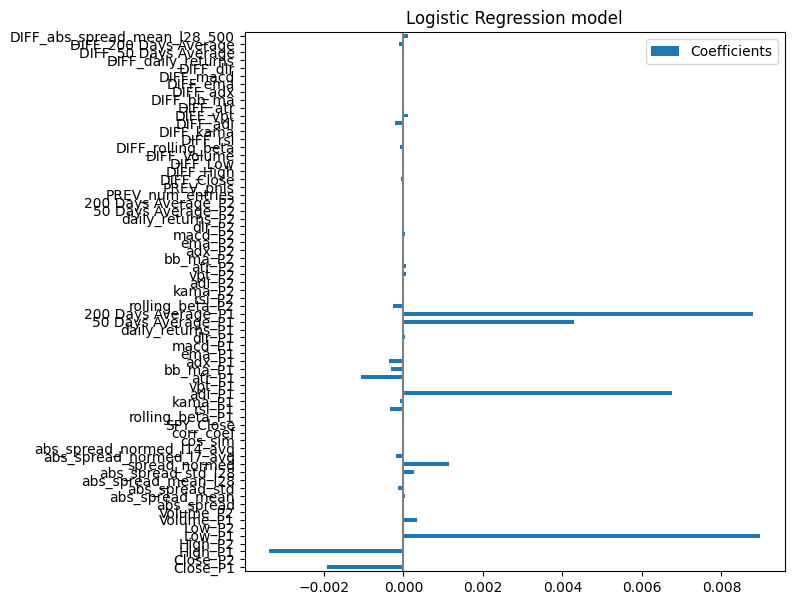

In [ ]:
pi = permutation_importance(gbm,X_test.drop(categorical_features,axis=1),y_test)

coefs = pd.DataFrame(
    pi['importances_mean'], columns=["Coefficients"], index=X_train.drop(categorical_features,axis=1).columns
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Logistic Regression model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

## Error Analysis

In [ ]:
preds = gbm.predict(X_test.drop(categorical_features,axis=1))

In [ ]:
results = pd.DataFrame({'preds':preds,'true':y_test})
results

In [ ]:
results.describe(np.arange(0,1,0.1))

In [ ]:
mae = (preds-y_test).abs().mean()
mae

In [ ]:
mean_abs_label = y_test.abs().mean()
mean_abs_label

In [ ]:
mae/mean_abs_label

In [ ]:
mae_AR1 = (X_test.PREV_pnls - pnl_not_0.true).abs().mean()
mae_AR1

In [ ]:
mae/mae_AR1

## Linear Regression

In [ ]:
scaler = StandardScaler().fit(X_train.drop(categorical_features,axis=1))
scaled_X_train = scaler.transform(X_train.drop(categorical_features,axis=1))
scaled_X_val = scaler.transform(X_val.drop(categorical_features,axis=1))
scaled_X_test = scaler.transform(X_test.drop(categorical_features,axis=1))

In [ ]:
regr = LinearRegression()

# Train the model using the training sets
regr.fit(scaled_X_train, y_train)

# Make predictions using the testing set
lr_preds = regr.predict(scaled_X_test)

In [ ]:
pi = permutation_importance(regr,scaled_X_test,y_test)

coefs = pd.DataFrame(
    pi['importances_mean'], columns=["Coefficients"], index=X_train.drop(categorical_features,axis=1).columns
)


coefs.plot(kind="barh", figsize=(9, 7))
plt.title("LR model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [ ]:
lr_results = pd.DataFrame({'preds':lr_preds,'true':y_test})
lr_results

In [ ]:
lr_pnl_is_0 = lr_results[lr_results.true==0]
lr_pnl_not_0 = lr_results[lr_results.true!=0]

In [ ]:
mae = (lr_pnl_not_0.preds-lr_pnl_not_0.true).abs().mean()

In [ ]:
mae/mean_abs_label

In [ ]:
# lr_results.loc[tmp_df.index]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(verbose=2,n_jobs=-1)

In [ ]:
rf.fit(X_train.drop(categorical_features,axis=1),y_train)

In [ ]:
preds = rf.predict(X_test.drop(categorical_features,axis=1))

In [ ]:
mae = (preds-y_test).abs().mean()
mae

In [ ]:
mae/mean_abs_label